# Gradient Vanishing Analysis in VGG19

### Motivation

Neural networks tend to learn very complex patterns in the data and we can leverage this by having networks with very deep layers. But having this power is like a double edged sword, where just stacking layers on top of each other is not going to ensure greater accuracy and we might stumble upon a problem called as `Vanishing Gradients`.

`Vanishing Gradients` problem takes away the power to learn from the data, after a point in time. In short the gradients which play a key role during backpropogation, they start to vanish (very close to 0), due to which weight optimization does not happen.

So in this notebook we wish to demonstrate this practically with CNNs and we first start with VGG19 network and understand how the gradients vary across different layers.

### Approach

Here we track and compares **average gradient norms per epoch** across multiple layers in VGG19 to observe potential vanishing gradients.

The intuition to choose these different layers across all the 19 layers in VGG is that, we want to have a broad sense of how gradients vary in each section of network i.e when the network just starts to learn in first few layers, when network is slightly deep enough to learn some features, when the network is very deep enough to capture nuanced features and the final layers which are used to generate classification probabilities.

This is will give us a better understanding how gradients behave in each of these sections.

#### Layers tracked:
- `features[0]`: Early convolutional layer
- `features[10]`: Mid-level convolutional layer
- `features[28]`: Deep convolutional layer
- `classifier[0]`: First fully connected layer

**Import libraries**

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from scipy.stats import gaussian_kde
from matplotlib.animation import FuncAnimation


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Load VGG19 pretrained model**

In [2]:
# Load pretrained VGG19 and modify classifier
vgg19 = models.vgg19(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, 10)

for module in vgg19.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False
        
vgg19 = vgg19.to(device)

/workspace/projects/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspace/projects/dl-lab-notebooks/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
class DoubleConvVGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(DoubleConvVGG19, self).__init__()
        
        original_vgg = models.vgg19(pretrained=True)
        original_layers = list(original_vgg.features)

        new_features = []
        for layer in original_layers:
            if isinstance(layer, nn.Conv2d):
                # Original conv + relu
                new_features.append(layer)
                new_features.append(nn.ReLU(inplace=True))
                
                # Duplicated conv + relu (same output channels as original)
                dup_conv = nn.Conv2d(
                    in_channels=layer.out_channels,
                    out_channels=layer.out_channels,
                    kernel_size=layer.kernel_size,
                    stride=layer.stride,
                    padding=layer.padding,
                    bias=(layer.bias is not None)
                )
                nn.init.kaiming_normal_(dup_conv.weight, mode='fan_out', nonlinearity='relu')
                new_features.append(dup_conv)
                new_features.append(nn.ReLU(inplace=True))

            elif isinstance(layer, nn.ReLU):
                # Already added relu after conv, skip
                continue
            else:
                # e.g., MaxPool or other layers
                new_features.append(layer)

        self.features = nn.Sequential(*new_features)
        self.avgpool = original_vgg.avgpool

        # Custom classifier (optional)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
vgg38 = DoubleConvVGG19(num_classes=10)

for module in vgg38.modules():
    if isinstance(module, nn.ReLU):
        module.inplace = False
        
vgg38 = vgg38.to(device)

**Verify no. of parameters to be trained**

In [5]:
trainable_params = sum(p.numel() for p in vgg38.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 161,219,018


**Register backward hook to log gradients**

In [6]:
# Gradient storage
epoch_gradients = {
    'conv1': [], 'conv_mid': [], 'conv_deep': [], 'fc1': []
}
batch_grads = {'conv1': [], 'conv_mid': [], 'conv_deep': [], 'fc1': []}

# Hook function
def register_hook(module, name):
    def hook(module, grad_input, grad_output):
        if grad_output[0] is not None:
            batch_grads[name].append(grad_output[0].norm().item())
    module.register_full_backward_hook(hook)

# Register hooks
register_hook(vgg38.features[0], 'conv1')
register_hook(vgg38.features[20], 'conv_mid')
register_hook(vgg38.features[-4], 'conv_deep')
register_hook(vgg38.classifier[0], 'fc1')

**Load CIFAR10 data and apply trasnformations**

In [7]:
# CIFAR-10 loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_dataset = datasets.CIFAR10(root='../data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

**Define loss and optimizer**

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg38.parameters(), lr=1e-4)

**Train the model and randomly log 20 gradients for each epoch per layer**

In [9]:
# Train for 10 epochs and log average gradient norms
for epoch in tqdm(range(10)):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg38(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # For each layer, sample 20 values from collected gradients
    for layer in batch_grads:
        grads = batch_grads[layer]
        if len(grads) >= 20:
            sampled = np.random.choice(grads, 20, replace=False)
        else:
            sampled = np.pad(grads, (0, 20 - len(grads)), constant_values=0)
        epoch_gradients[layer].append(sampled)
        batch_grads[layer].clear()

    print(f"Epoch {epoch+1} complete")

 10%|█         | 1/10 [06:23<57:33, 383.71s/it]

Epoch 1 complete


 20%|██        | 2/10 [13:00<52:12, 391.58s/it]

Epoch 2 complete


 30%|███       | 3/10 [19:37<45:58, 394.05s/it]

Epoch 3 complete


 40%|████      | 4/10 [26:14<39:30, 395.15s/it]

Epoch 4 complete


 50%|█████     | 5/10 [32:51<32:58, 395.73s/it]

Epoch 5 complete


 60%|██████    | 6/10 [39:28<26:24, 396.11s/it]

Epoch 6 complete


 70%|███████   | 7/10 [46:05<19:49, 396.36s/it]

Epoch 7 complete


 80%|████████  | 8/10 [52:41<13:12, 396.47s/it]

Epoch 8 complete


 90%|█████████ | 9/10 [59:18<06:36, 396.57s/it]

Epoch 9 complete


100%|██████████| 10/10 [1:05:55<00:00, 395.56s/it]

Epoch 10 complete


In [10]:

layers = ['conv1', 'conv_mid', 'conv_deep', 'fc1']

In [11]:
def create_log_hist_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='log_hist_gradients.gif'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Log-spaced bins from 1e-10 to 1e0 (1)
    log_bins = np.logspace(-10, 0, 50)

    def update(epoch):
        ax.clear()
        for layer in layers:
            data = epoch_gradients[layer][epoch]
            if len(data) > 1 and np.isfinite(data).all():
                log_data = np.abs(data) + 1e-10  # Avoid log(0)
                hist, bins = np.histogram(log_data, bins=log_bins, density=True)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                ax.plot(bin_centers, hist, label=layer)

        ax.set_xscale('log')
        ax.set_xlim(1e-10, 1)
        ax.set_ylim(0, None)
        ax.set_title(f"Log-Scaled Gradient Histogram - Epoch {epoch + 1}")
        ax.set_xlabel("Gradient Magnitude (log scale)")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, which="both", ls="--", linewidth=0.5)

    ani = FuncAnimation(fig, update, frames=num_epochs, repeat=False)
    ani.save(save_path, writer='pillow', fps=1)
    print(f"Saved animation to {save_path}")


Saved animation to log_hist_gradients_vgg38.gif


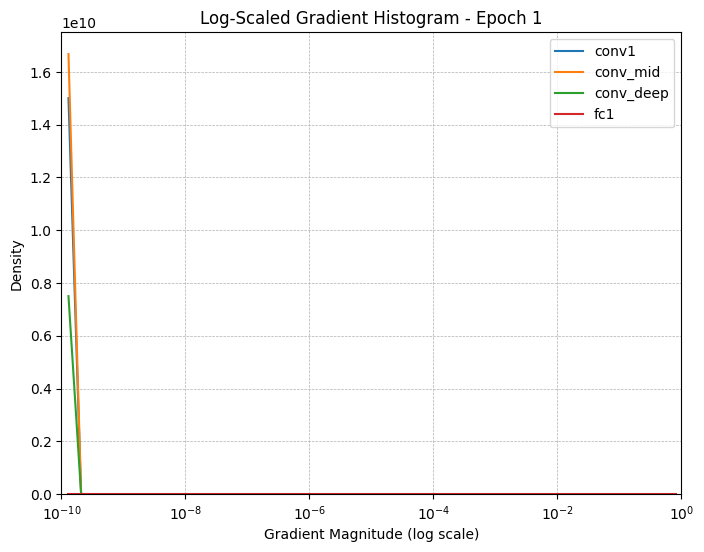

In [12]:
create_log_hist_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='log_hist_gradients_vgg38.gif')

![Histograms](log_hist_gradients_vgg19.gif)

**Observations**

- The graph shows how the distribution of gradient magnitudes (on a log scale) evolves across epochs for each layer.
- As we can see the for each of the considered layers, the gradient magnitude lies between 1e-3 to 1, which is still on the higher side and the gradients haven't vanished.
- This could be happening because VGG19 has 19 layers and it is still not deep enough for any of the layers to vanish just yet (keeping in mind that the above network was only trained for 10 epochs).
- To further extend our experiment lets increase the number of layers in VGG19 and see if this behavior stays put.